# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files

**Date**: October 10th 2025

**Student Name**: Valeria Oliva Hdez

**Professor**: Pablo Camarillo Ramirez

## **1. Create SparkSession**

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 04:24:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **2. Create a data stream from files**

In [2]:
from valeriaoliva.spark_utils import SparkUtils
from pyspark.sql.functions import col, to_timestamp, window

logs_schema = SparkUtils.generate_schema([
    ("time", "string"), 
    ("level", "string"), 
    ("action", "string"), 
    ("event", "string"), 
    ("user","string") ])


logs_df = spark.readStream \
            .format("json") \
            .schema(logs_schema) \
            .load("/opt/spark/work-dir/data/logs")

logs_ts = logs_df.withColumn("ts", to_timestamp("time", "yyyy-MM-dd'T'HH:mm:ssXXX"))
errors = logs_ts.filter(col("level") == "ERROR")
alerts = (errors.groupBy(window(col("ts"), "10 seconds"), col("action"))
                .count()
                .filter(col("count") >= 2))

query = alerts.writeStream \
            .outputMode("update") \
            .format("console") \
            .option("truncate", False) \
            .start()

query.awaitTermination(30) # Wait 30 seconds before closing the stream

-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |action |count|
+------------------------------------------+-------+-----+
|{2025-10-10 04:24:40, 2025-10-10 04:24:50}|payment|2    |
|{2025-10-10 04:24:50, 2025-10-10 04:25:00}|payment|5    |
|{2025-10-10 04:24:40, 2025-10-10 04:24:50}|user   |3    |
|{2025-10-10 04:24:50, 2025-10-10 04:25:00}|order  |2    |
|{2025-10-10 04:24:50, 2025-10-10 04:25:00}|user   |3    |
|{2025-10-10 04:24:40, 2025-10-10 04:24:50}|order  |4    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |action |count|
+------------------------------------------+-------+-----+
|{2025-10-10 04:25:00, 2025-10-10 04:25:10}|order  |4    |
|{2025-10-10 04:25:00, 2025-10-10 04:25:10}|payment|2    |
|{2025-10-10 04:25:10, 2025-10-10 04:25:20}|user   |2    |
|{2025-10-10 04:25:00, 2025-10-10 04:25:10}|user   |4    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |action |count|
+------------------------------------------+-------+-----+
|{2025-10-10 04:25:10, 2025-10-10 04:25:20}|order  |4    |
|{2025-10-10 04:25:10, 2025-10-10 04:25:20}|payment|5    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+------+------+-----+
|window|action|count|
+------+------+-----+
+------+------+-----+



False

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |action |count|
+------------------------------------------+-------+-----+
|{2025-10-10 04:25:20, 2025-10-10 04:25:30}|payment|3    |
|{2025-10-10 04:25:20, 2025-10-10 04:25:30}|user   |2    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 5
-------------------------------------------
+------+------+-----+
|window|action|count|
+------+------+-----+
+------+------+-----+



1. ¿De donde obtuviste la información para usar las ventanas de tiempo? Por favor agrega esas referencias en el Notebook.

https://spark.apache.org/docs/3.5.1/structured-streaming-programming-guide.html

De los ejemplos de la sección de Operations on streaming DataFrames/Datasets, como este:

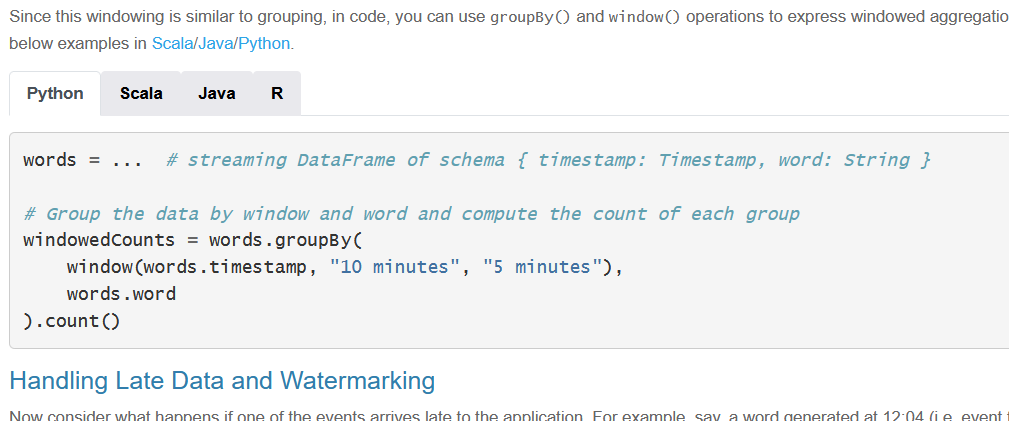

2. ¿Porque decidiste que estas ventanas de tiempo fueran de 10 segundos?

Quedó en 10 segundos porque tomé como referncia el ejemplo de la página para hacer el groupby. Solo cambié el tiempo de min a segundos (5 segundos me parecía poco tiempo), quité el slide de 5 min porque no lo creí necesario y puse el filtro para que solo mostrara las acciones con conteo de 2 o más. 

In [ ]:
sc.stop()